# CNTL CCKWs event selection

## Import packages

In [38]:
import sys
import numpy as np
import pandas as pd
import netCDF4 as nc

from matplotlib import pyplot as plt

sys.path.append('/home/b11209013/Package')
import DataProcess as dp   #type: ignore
import SignalProcess as sp #type: ignore

## Functions

In [39]:
def is_within_region(wnm, frm, wnm_min, wnm_max, frm_min, frm_max, kel_sign=1):
    kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k
    
    return (
        (wnm > wnm_min) & (wnm < wnm_max) &
        (frm > kel_sign * frm_min) & (frm < kel_sign * frm_max) &
        (frm < kel_sign * kel_curves(90, wnm)) &
        (frm > kel_sign * kel_curves(8, wnm))
    )

## Load data

In [40]:
with nc.Dataset('/work/b11209013/2024_Research/MPAS/merged_data/NCRF/q1.nc', 'r') as f:
    lon : np.ndarray = f.variables['lon'][:]
    lat : np.ndarray = f.variables['lat'][:]
    lev : np.ndarray = f.variables['lev'][:]
    time: np.ndarray = f.variables['time'][:]
    lat_lim = np.where((lat >= -5) & (lat <= 5))[0]
    
    lat : np.ndarray = lat[lat_lim]
    q1       = f.variables['q1'][:, :, lat_lim, :]

ltime, llev, llat, llon = q1.shape

## Vertical integrated Q1

In [41]:
q1_ave = (q1[:, 1:] + q1[:, :-1]) / 2
q1_int = -np.sum(q1_ave*np.diff(lev)[None, :, None, None]*100, axis=1) *86400/9.8/2.5e6

## Process Data

### Symmetrize data

In [42]:
fmt = dp.Format(lat)

q1_sym = fmt.sym(q1_int)

print(q1_sym.shape)

(368, 720)


### bandpass filter

In [43]:
wn = np.fft.fftfreq(llon, d = 1/llon).astype(int) # unit: None
fr = np.fft.fftfreq(ltime, d = 1/4) # unit: CPD

wnm, frm = np.meshgrid(wn, fr)

cond1 = is_within_region(
    wnm, frm,
    wnm_min=1, wnm_max=14,
    frm_min=1/20, frm_max=1/2.5
)

cond2 = is_within_region(
    wnm, frm,
    wnm_min=-14, wnm_max=-1,
    frm_min=1/20, frm_max=1/2.5,
    kel_sign=-1
)

### FFT on q1_sym

In [44]:
q1_fft = np.array([np.fft.fft(q1_sym[i]) for i in range(ltime)])
q1_fft = np.array([np.fft.ifft(q1_fft[:, i]) for i in range(llon)]).T

### Filt with the filter

In [45]:
mask = np.where(cond1 | cond2, 1, 0)
q1_filted = mask * q1_fft

### reconstruct

In [46]:
q1_recon = np.array([np.fft.fft(q1_filted[:, i]) for i in range(llon)]).T
q1_recon = np.array([np.fft.ifft(q1_recon[i]) for i in range(ltime)])

q1_recon = np.real(q1_recon)

## Select events

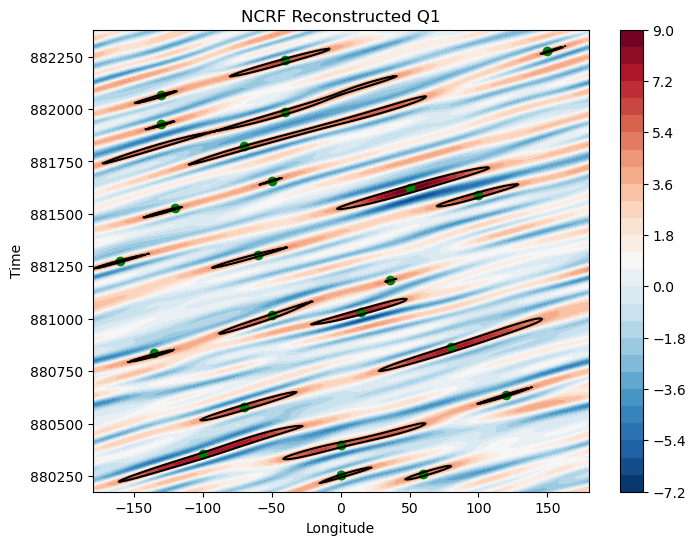

In [47]:
g99 = q1_recon.mean() + 1.96*q1_recon.std() # 95% z-test, single tailed

plt.figure(figsize=(8, 6))
c = plt.contourf(lon, time, q1_recon, levels=30, cmap='RdBu_r')
plt.contour(lon, time, q1_recon, levels=[g99], colors='k')

plt.scatter(-100, time[30], c="g")
plt.scatter(0, time[13], c="g")
plt.scatter(60, time[14], c="g")
plt.scatter(0, time[37], c="g")
plt.scatter(120, time[77], c="g")
plt.scatter(-70, time[67], c="g")
plt.scatter(80, time[115], c="g")
plt.scatter(0, time[13], c="g")
plt.scatter(15, time[143], c="g")
plt.scatter(-50, time[140], c="g")
plt.scatter(-60, time[188], c="g")
plt.scatter(-160, time[183], c="g")
plt.scatter(50, time[241], c="g")
plt.scatter(100, time[236], c="g")
plt.scatter(-120, time[225], c="g")
plt.scatter(-70, time[275], c="g")
plt.scatter(-40, time[302], c="g")
plt.scatter(-130, time[315], c="g")
plt.scatter(-40, time[343], c="g")
plt.scatter(150, time[350], c="g")
plt.scatter(-130, time[292], c="g")
plt.scatter(-135, time[110], c="g")
plt.scatter(36, time[168], c="g")
plt.scatter(-50, time[247], c="g")

plt.xlabel('Longitude')
plt.ylabel('Time')
plt.title('NCRF Reconstructed Q1')
plt.colorbar(c)
plt.savefig('sel_image/NCRF_Q1_recon.png')
plt.show()

## Save to file

### Time and longitude selected

In [49]:
lon_sel = np.array([-100, 0, 60, 0, 120, -70, 80, 0, 15, -50, -60, -160, 50, 100, -120, -70, -40, -130, -40, 150, -130, -135, 36, -50])
time_sel = np.array([30, 13, 14, 37, 77, 67, 115, 13, 143, 140, 188, 183, 241, 236, 225, 275, 302, 315, 343, 350, 292, 110, 168, 247]) 

lon_ref = np.array([np.argmin(np.abs(lon - l)) for l in lon_sel])
time_ref = time_sel
print("Longitude of events", len(lon_ref))
output_list = [lon_ref, time_ref]

Longitude of events 24


### Save file

In [50]:
np.save('Q1_sel/NCRF.npy', output_list)